In [1]:
import pandas as pd
import s3fs

In [2]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "williamolivier"

FILE_PATH_S3_FVDEP = f"{MY_BUCKET}/diffusion/epci_6_clusters.csv"
with fs.open(FILE_PATH_S3_FVDEP, "rb") as file:
    epci_features = pd.read_csv(file)


In [3]:
epci_features.sample()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,...,distance_entrant_50<x<infkm_rouge,nb_sortant_50<x<infkm_rouge,distance_sortant_50<x<infkm_rouge,nb_intra_rouge,distance_intra_rouge,total_entrants,total_sortants,sortant_sur_entrant,cluster,color
106,106,111,111,200035772,"['Saint-Remimont', 'Vroncourt', 'Lalœuf', 'Dia...","['54486', '54592', '54291', '54156', '54132', ...","['54', '54', '54', '54', '54', '54', '54', '54...",14259.0,1063.911068,6042.005409,...,35643.719513,52.336979,47102.672766,1282.322217,5975.977733,4607.951351,955.968391,0.207461,3,"(np.float64(0.12156862745098039), np.float64(0..."


étape 1 : Il faut choisir un clustering parmi les 4 (on demandera l'avis de Nicolas) et pour chaque cluster trouver une composition moyenne des transports en communs utilisé (ex 80% metro et 10% train et 10% bus pour le cluster ou y'a que paris, etc)

étape 2 : Il faut écrire un dictionnaire qui recense pour chaque type de transport en commun son émission moy/km 

étape 3 : Créer une nouvelle colonne sur un des 4 tableaux (selon le clustering retenu) qui donnerait une émission moyenne pour chaque EPCI (soit global, soit par type de flux (séparer rouge et jaune? à voir))

-> pour cette étape voir si + pertinent de prendre les flux entrant ou sortant ? ou une moyenne des 2 ?

étape 4 : trouver un moyen de repérer les mauvais élèves (par exemple ceux dont l'émission associée calculée est aberrante ou plus élevée par rapport aux autres EPCI du même cluster)

-> pour cette étape trouver un indicateurs pour détecter les mauvais élève (ex arbitraire 50% aus dessus de la moyenne) mais voir si on peut trouver un meilleur indicateur bien justifier

In [4]:
'''
# Etape 1

# Pour l'instant choix du clustering à 7 clusters
# On prend en compte à la fois les flux entrants et les flux sortants pour faire les calculs

epci_features=epci_features_7 # il suffira de changer le numéro du clustering choisi ici

epci_features["nombre_total_de_flux_par_epci"]=(
    epci_features["nb_entrant_>50km_rouge"]
    +epci_features["nb_entrant_<50km_rouge"]
    +epci_features["nb_sortant_>50km_rouge"]
    +epci_features["nb_sortant_<50km_rouge"]
    +epci_features["nb_intra_rouge"]
    +epci_features["nb_entrant_>50km_vert"]
    +epci_features["nb_entrant_<50km_vert"]
    +epci_features["nb_sortant_>50km_vert"]
    +epci_features["nb_sortant_<50km_vert"]
    +epci_features["nb_intra_vert"]
    +epci_features["nb_entrant_>50km_jaune"]
    +epci_features["nb_entrant_<50km_jaune"]
    +epci_features["nb_sortant_>50km_jaune"]
    +epci_features["nb_sortant_<50km_jaune"]
    +epci_features["nb_intra_jaune"]
    )

# Calcul de la proportion d'individus qui se rendent au travail en voiture
epci_features["proportion_individus_flux_rouges"] = (
    (epci_features["nb_entrant_>50km_rouge"]
    + epci_features["nb_entrant_<50km_rouge"]
    + epci_features["nb_sortant_>50km_rouge"]
    + epci_features["nb_sortant_<50km_rouge"]
    + epci_features["nb_intra_rouge"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

# Calcul de la proportion d'individus qui se rendent au travail en transports en commun
epci_features["proportion_individus_flux_jaunes"] = (
    (epci_features["nb_entrant_>50km_jaune"]
    + epci_features["nb_entrant_<50km_jaune"]
    + epci_features["nb_sortant_>50km_jaune"]
    + epci_features["nb_sortant_<50km_jaune"]
    + epci_features["nb_intra_jaune"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

# Calcul de la proportion d'individus qui se rendent au travail à pieds / en vélo / qui télétravaillent ou travaillent à domicile
epci_features["proportion_individus_flux_verts"] = (
    (epci_features["nb_entrant_>50km_vert"]
    + epci_features["nb_entrant_<50km_vert"]
    + epci_features["nb_sortant_>50km_vert"]
    + epci_features["nb_sortant_<50km_vert"]
    + epci_features["nb_intra_vert"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

print(epci_features["proportion_individus_flux_rouges"].head())
print(epci_features["proportion_individus_flux_jaunes"].head())
print(epci_features["proportion_individus_flux_verts"].head())
print(epci_features["proportion_individus_flux_rouges"].head()
    +epci_features["proportion_individus_flux_jaunes"].head()
    +epci_features["proportion_individus_flux_verts"].head())
# les résultats sont parfaitement logiques ici
'''

'\n# Etape 1\n\n# Pour l\'instant choix du clustering à 7 clusters\n# On prend en compte à la fois les flux entrants et les flux sortants pour faire les calculs\n\nepci_features=epci_features_7 # il suffira de changer le numéro du clustering choisi ici\n\nepci_features["nombre_total_de_flux_par_epci"]=(\n    epci_features["nb_entrant_>50km_rouge"]\n    +epci_features["nb_entrant_<50km_rouge"]\n    +epci_features["nb_sortant_>50km_rouge"]\n    +epci_features["nb_sortant_<50km_rouge"]\n    +epci_features["nb_intra_rouge"]\n    +epci_features["nb_entrant_>50km_vert"]\n    +epci_features["nb_entrant_<50km_vert"]\n    +epci_features["nb_sortant_>50km_vert"]\n    +epci_features["nb_sortant_<50km_vert"]\n    +epci_features["nb_intra_vert"]\n    +epci_features["nb_entrant_>50km_jaune"]\n    +epci_features["nb_entrant_<50km_jaune"]\n    +epci_features["nb_sortant_>50km_jaune"]\n    +epci_features["nb_sortant_<50km_jaune"]\n    +epci_features["nb_intra_jaune"]\n    )\n\n# Calcul de la proportion

In [5]:
'''
# Même chose avec la distance

epci_features["distance_totale_de_flux_par_epci"]=(
    epci_features["distance_entrant_>50km_rouge"]*epci_features["nb_entrant_>50km_rouge"]
    + epci_features["distance_entrant_<50km_rouge"]*epci_features["nb_entrant_<50km_rouge"]
    + epci_features["distance_sortant_>50km_rouge"]*epci_features["nb_sortant_>50km_rouge"]
    + epci_features["distance_sortant_<50km_rouge"]*epci_features["nb_sortant_<50km_rouge"]
    + epci_features["distance_intra_rouge"]*epci_features["nb_intra_rouge"]
    + epci_features["distance_entrant_>50km_vert"]*epci_features["nb_entrant_>50km_vert"]
    + epci_features["distance_entrant_<50km_vert"]*epci_features["nb_entrant_<50km_vert"]
    + epci_features["distance_sortant_>50km_vert"]*epci_features["nb_sortant_>50km_vert"]
    + epci_features["distance_sortant_<50km_vert"]*epci_features["nb_sortant_<50km_vert"]
    + epci_features["distance_intra_vert"]*epci_features["nb_intra_vert"]
    + epci_features["distance_entrant_>50km_jaune"]*epci_features["nb_entrant_>50km_jaune"]
    + epci_features["distance_entrant_<50km_jaune"]*epci_features["nb_entrant_<50km_jaune"]
    + epci_features["distance_sortant_>50km_jaune"]*epci_features["nb_sortant_>50km_jaune"]
    + epci_features["distance_sortant_<50km_jaune"]*epci_features["nb_sortant_<50km_jaune"]
    + epci_features["distance_intra_jaune"]*epci_features["nb_intra_jaune"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus en voiture
epci_features["proportion_distance_flux_rouges"] = (
    (epci_features["distance_entrant_>50km_rouge"]*epci_features["nb_entrant_>50km_rouge"]
    + epci_features["distance_entrant_<50km_rouge"]*epci_features["nb_entrant_<50km_rouge"]
    + epci_features["distance_sortant_>50km_rouge"]*epci_features["nb_sortant_>50km_rouge"]
    + epci_features["distance_sortant_<50km_rouge"]*epci_features["nb_sortant_<50km_rouge"]
    + epci_features["distance_intra_rouge"]*epci_features["nb_intra_rouge"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus en transports en commun
epci_features["proportion_distance_flux_jaunes"] = (
    (epci_features["distance_entrant_>50km_jaune"]*epci_features["nb_entrant_>50km_jaune"]
    + epci_features["distance_entrant_<50km_jaune"]*epci_features["nb_entrant_<50km_jaune"]
    + epci_features["distance_sortant_>50km_jaune"]*epci_features["nb_sortant_>50km_jaune"]
    + epci_features["distance_sortant_<50km_jaune"]*epci_features["nb_sortant_<50km_jaune"]
    + epci_features["distance_intra_jaune"]*epci_features["nb_intra_jaune"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus à pieds / en vélo / qui télétravaillent ou travaillent à domicile
epci_features["proportion_distance_flux_verts"] = (
    (epci_features["distance_entrant_>50km_vert"]*epci_features["nb_entrant_>50km_vert"]
    + epci_features["distance_entrant_<50km_vert"]*epci_features["nb_entrant_<50km_vert"]
    + epci_features["distance_sortant_>50km_vert"]*epci_features["nb_sortant_>50km_vert"]
    + epci_features["distance_sortant_<50km_vert"]*epci_features["nb_sortant_<50km_vert"]
    + epci_features["distance_intra_vert"]*epci_features["nb_intra_vert"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

print(epci_features["proportion_distance_flux_rouges"].head())
print(epci_features["proportion_distance_flux_rouges"].mean())
print(epci_features["proportion_distance_flux_jaunes"].head())
print(epci_features["proportion_distance_flux_jaunes"].mean())
print(epci_features["proportion_distance_flux_verts"].head())
print(epci_features["proportion_distance_flux_verts"].mean())
print((epci_features["proportion_distance_flux_rouges"]+epci_features["proportion_distance_flux_jaunes"]+epci_features["proportion_distance_flux_verts"]).head())
# La somme de toutes les proportions fait 1
# Les résultats sont logiques
'''

'\n# Même chose avec la distance\n\nepci_features["distance_totale_de_flux_par_epci"]=(\n    epci_features["distance_entrant_>50km_rouge"]*epci_features["nb_entrant_>50km_rouge"]\n    + epci_features["distance_entrant_<50km_rouge"]*epci_features["nb_entrant_<50km_rouge"]\n    + epci_features["distance_sortant_>50km_rouge"]*epci_features["nb_sortant_>50km_rouge"]\n    + epci_features["distance_sortant_<50km_rouge"]*epci_features["nb_sortant_<50km_rouge"]\n    + epci_features["distance_intra_rouge"]*epci_features["nb_intra_rouge"]\n    + epci_features["distance_entrant_>50km_vert"]*epci_features["nb_entrant_>50km_vert"]\n    + epci_features["distance_entrant_<50km_vert"]*epci_features["nb_entrant_<50km_vert"]\n    + epci_features["distance_sortant_>50km_vert"]*epci_features["nb_sortant_>50km_vert"]\n    + epci_features["distance_sortant_<50km_vert"]*epci_features["nb_sortant_<50km_vert"]\n    + epci_features["distance_intra_vert"]*epci_features["nb_intra_vert"]\n    + epci_features["dist

In [6]:
# Etape 2

# SOURCE : https://www.data.gouv.fr/fr/datasets/emission-de-co2e-par-voyageur-kilometre-sur-le-reseau/

pollution_au_km={
    "voiture":"0.097", 
    "bus":"0.092", 
    "metro":"0.0038",
    "tram":"0.0032",
    "transilien":"0.0066",
    "TER":"0.02693"
}

In [7]:
# CALCUL EMISSIONS TOTALES 

pollution_au_km_flux_jaunes ={
    "Bus": 0.092, 
    "Métro/tram/transilien": 0.0045,
    "TER": 0.02693
}

pollution_au_km_flux_rouges = 0.144

# Dictionnaire avec les valeurs choisies pour chaque mode de TC en % de la distance parcourue en TC 

flux_jaunes_detail = {
    0 : { #Villes moyennes
        "Métro/tram/transilien": 0.2,
        "TER": 0.4,   
        "Bus": 0.4   
    },
    1 : { #Banlieue Paris
        "Métro/tram/transilien": 0.7,  
        "TER": 0.1,    
        "Bus": 0.2    
    },
    2 : { #Paris
        "Métro/tram/transilien": 0.8,  
        "TER": 0.1,   
        "Bus": 0.1   
    },
    3 : { #Autres
        "Métro/tram/transilien": 0, 
        "TER": 0.5,    
        "Bus": 0.5     
    },
    4 : { #Grandes villes
        "Métro/tram/transilien" : 0.5,
        "TER" : 0.2,
        "Bus" : 0.3
    },
    5 : { # Banlieue proche Paris
        "Métro/tram/transilien" : 0.7,
        "TER" : 0.1,
        "Bus" : 0.2
    }
}


# ici flux intra + moyenne des flux sortants et entrants 
epci_features["moyenne_flux_rouges"] = (
    epci_features['distance_intra_rouge'] +(
    epci_features['distance_entrant_<10km_rouge'] + 
    epci_features['distance_entrant_10<x<20km_rouge'] + 
    epci_features['distance_entrant_20<x<30km_rouge']  +
    epci_features['distance_entrant_30<x<40km_rouge'] + 
    epci_features['distance_entrant_40<x<50km_rouge']+ 
    epci_features['distance_entrant_50<x<infkm_rouge']  + 
    epci_features['distance_sortant_<10km_rouge']  + 
    epci_features['distance_sortant_10<x<20km_rouge']  + 
    epci_features['distance_sortant_20<x<30km_rouge'] +
    epci_features['distance_sortant_30<x<40km_rouge']+ 
    epci_features['distance_sortant_40<x<50km_rouge']+ 
    epci_features['distance_sortant_50<x<infkm_rouge'])/2)
    

epci_features['pollution_flux_rouges'] = epci_features['moyenne_flux_rouges'] * pollution_au_km_flux_rouges

epci_features["moyenne_flux_jaunes"] = (
    epci_features['distance_intra_jaune']+ (
    epci_features['distance_entrant_<10km_jaune']+ 
    epci_features['distance_entrant_10<x<20km_jaune'] + 
    epci_features['distance_entrant_20<x<30km_jaune'] +
    epci_features['distance_entrant_30<x<40km_jaune'] + 
    epci_features['distance_entrant_40<x<50km_jaune'] + 
    epci_features['distance_entrant_50<x<infkm_jaune'] + 
    epci_features['distance_sortant_<10km_jaune'] + 
    epci_features['distance_sortant_10<x<20km_jaune']  + 
    epci_features['distance_sortant_20<x<30km_jaune']+
    epci_features['distance_sortant_30<x<40km_jaune'] + 
    epci_features['distance_sortant_40<x<50km_jaune'] + 
    epci_features['distance_sortant_50<x<infkm_jaune'])/2)


for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Appliquer la répartition pour chaque mode de transport en fonction du cluster
    epci_features[f'distance_{transport}'] = epci_features['moyenne_flux_jaunes'] * \
        epci_features['cluster'].map(lambda cluster: flux_jaunes_detail.get(cluster, {}).get(transport, 0))

for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Calculer la pollution en multipliant la distance par les émissions par km pour chaque mode
    epci_features[f'pollution_{transport}'] = epci_features[f'distance_{transport}'] * pollution_au_km_flux_jaunes[transport]

epci_features['pollution_flux_jaunes'] = (
    epci_features['pollution_Métro/tram/transilien'] + epci_features['pollution_TER'] + 
    epci_features['pollution_Bus']) 

epci_features['pollution_totale'] = (
    epci_features['pollution_flux_rouges'] + epci_features['pollution_flux_jaunes'])


In [8]:
epci_features[epci_features['cluster']==2]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,...,pollution_flux_rouges,moyenne_flux_jaunes,distance_Métro/tram/transilien,distance_TER,distance_Bus,pollution_Métro/tram/transilien,pollution_TER,pollution_Bus,pollution_flux_jaunes,pollution_totale
256,256,269,269,200054781,"['Paris 2e Arrondissement', 'Paris 9e Arrondis...","['75102', '75109', '75111', '75117', '75103', ...","['75', '75', '75', '75', '75', '75', '75', '75...",2145906.0,161930.110098,1.128286e+06,...,1.299888e+06,1.861650e+07,1.489320e+07,1.861650e+06,1.861650e+06,67019.416486,50134.246832,171271.842131,288425.50545,1.588313e+06


In [9]:
'''
# Identifier les mauvais élèves

# Trier les EPCI par pollution totale dans chaque cluster
mauvais_eleves_par_cluster = epci_features.sort_values(['cluster', 'pollution_flux_rouges'], ascending=[True, False])

# Garder les 5 pires par cluster
top_n = 5
mauvais_eleves_par_cluster = mauvais_eleves_par_cluster.groupby('cluster').head(top_n)

cols = ['cluster', 'NOM', 'pollution_flux_rouges']
print(mauvais_eleves_par_cluster[cols])
'''

"\n# Identifier les mauvais élèves\n\n# Trier les EPCI par pollution totale dans chaque cluster\nmauvais_eleves_par_cluster = epci_features.sort_values(['cluster', 'pollution_flux_rouges'], ascending=[True, False])\n\n# Garder les 5 pires par cluster\ntop_n = 5\nmauvais_eleves_par_cluster = mauvais_eleves_par_cluster.groupby('cluster').head(top_n)\n\ncols = ['cluster', 'NOM', 'pollution_flux_rouges']\nprint(mauvais_eleves_par_cluster[cols])\n"

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pollution_par_cluster(df, cluster_id, label_col='SIREN_EPCI'):
    """
    Affiche un barplot de la pollution totale pour un cluster donné.

    Paramètres :
        df : DataFrame contenant les colonnes 'cluster' et 'pollution_totale'
        cluster_id : identifiant du cluster à visualiser
        label_col : colonne à afficher sur l'axe des y (par défaut 'INSEE_COM')
    """
    # Filtrer le cluster
    subset = df[df['cluster'] == cluster_id].copy()

    if subset.empty:
        print(f"Aucun EPCI trouvé pour le cluster {cluster_id}")
        return
    # Trier du moins au plus polluant
    subset = subset.sort_values('pollution_totale', ascending=True)

    # Créer le barplot
    hauteur = max(6, len(subset) * 0.4)  # 0.4 par ligne, minimum 6
    plt.figure(figsize=(8, 6))
    barplot = sns.barplot(
        data=subset,
        x='pollution_totale',
        y=label_col,
        palette='Reds')

    plt.title(f"Pollution totale – Cluster : {cluster_id}")
    plt.xlabel("kg CO₂")
    plt.ylabel("EPCI")

    # Affichage des valeurs sur les barres
    for container in barplot.containers:
        barplot.bar_label(container, label_type="edge", padding=3)

    plt.tight_layout()
    plt.show()


In [11]:
mauvais_eleves = []

for cluster_id in epci_features['cluster'].unique():
    # On sélectionne les lignes du cluster
    groupe = epci_features[epci_features['cluster'] == cluster_id]
    seuil = groupe['pollution_flux_rouges'].mean() + 2*groupe['pollution_flux_rouges'].std()
    mauvais = groupe[groupe['pollution_flux_rouges'] > seuil]
    mauvais_eleves.append(mauvais)

# On concatène tous les mauvais élèves en un seul DataFrame
mauvais_eleves_par_cluster = pd.concat(mauvais_eleves)


In [12]:
mauvais_eleves_par_cluster['cluster']

245    3
366    3
472    3
549    3
601    3
689    3
758    3
831    3
840    3
841    3
842    3
844    3
882    3
45     0
830    0
836    0
843    0
262    5
270    1
Name: cluster, dtype: int64

/tmp/ipykernel_7107/2274246121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


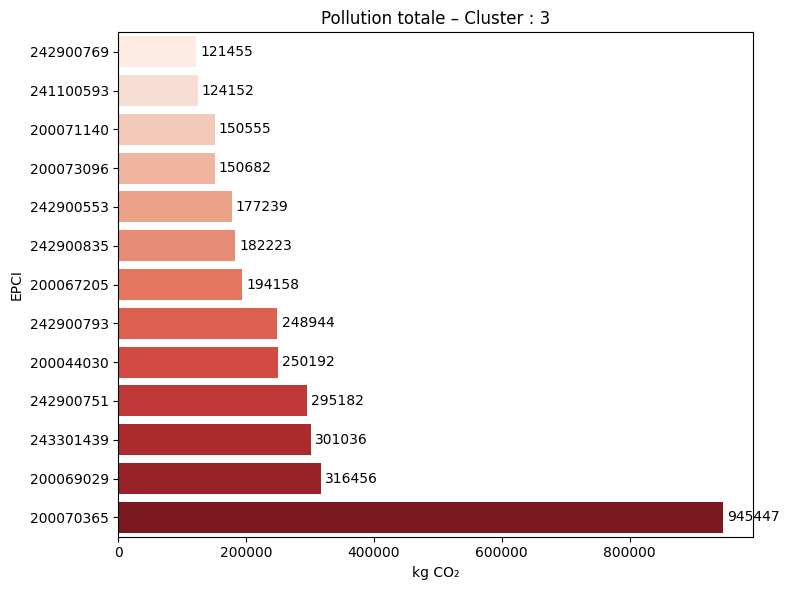

None


/tmp/ipykernel_7107/2274246121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


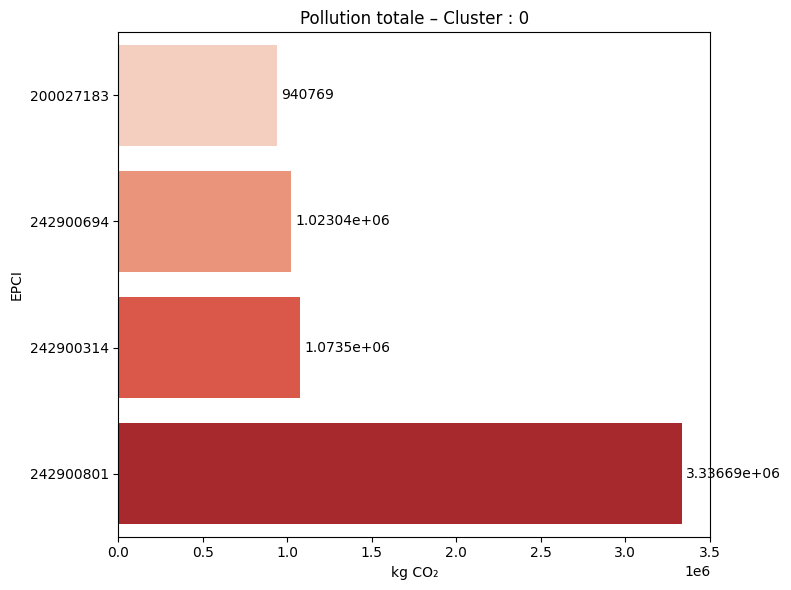

None


/tmp/ipykernel_7107/2274246121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


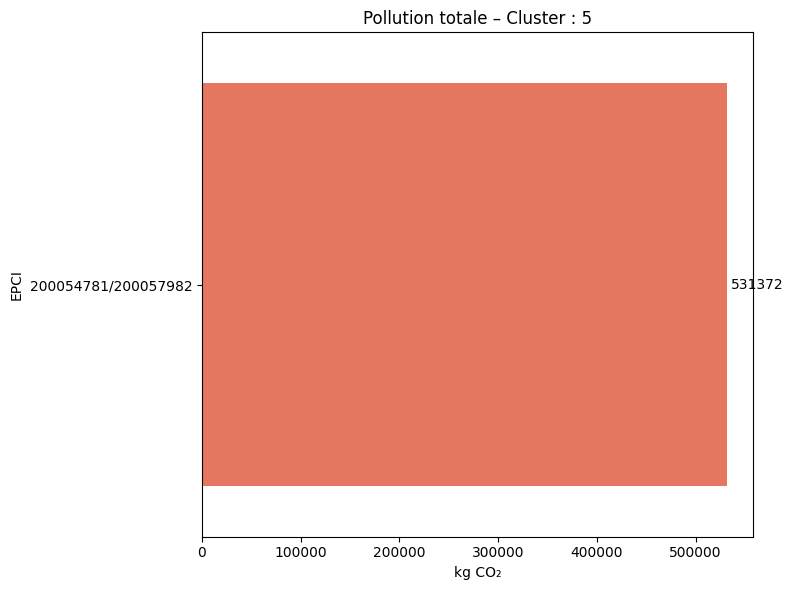

None


/tmp/ipykernel_7107/2274246121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


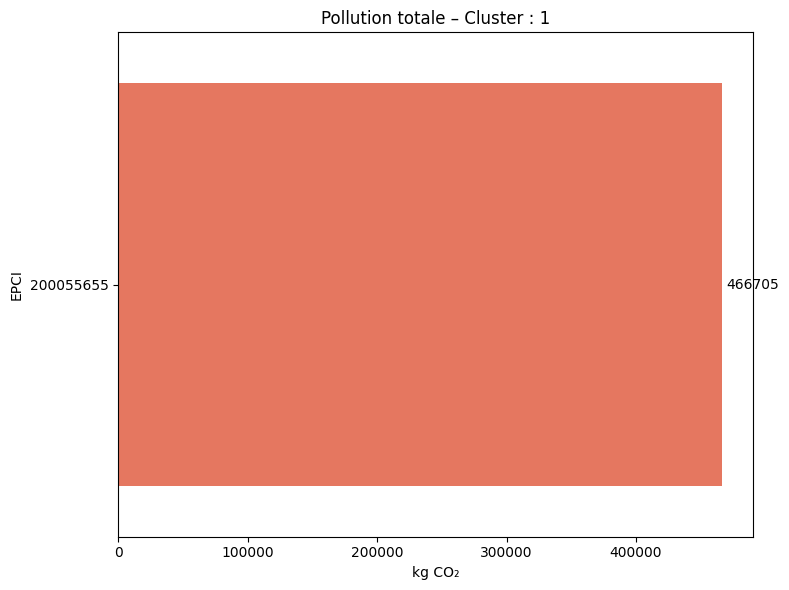

None


In [13]:
print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=3))
print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=0))
print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=5))
print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=1))

In [14]:
# Faire la partie simulation de réduction des émissions via politique de décarbonation

# BONUS : étude socio

In [15]:
from script import df_dossier_complet_brut
from script import df_meta_dossier_complet_brut

/home/onyxia/work/statapp/script.py:19: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:24: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:34: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:142: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contours_comm["centroid"] = contours_comm.geometry.centroid
/home/onyxia/work/statapp/script.py:151: UserWarning: Geometry is in a geographic CRS. Results from 'centroid'

antully: (46.89232199838103, 4.402852764409862)
le tremblay-omonville: (49.12081156432765, 0.9143802127565656)
vaux-lès-mouzon: (49.60389494206806, 5.136483053287144)
anchenoncourt-et-chazel: (47.8616809003776, 6.11534440434135)
culoz-béon: (45.85633732729717, 5.772905566192263)
domèvre-sur-avière: (48.22223470040439, 6.388423941842605)
bernoy-le-château: (49.32120314158208, 3.3070156677330558)
videcosville: (49.566672646936, -1.3714795795608266)
saint-agrève: (45.00542393638767, 4.413096930429594)
le bourg-d'oisans: (45.0340588974907, 6.032836629436181)


In [16]:
df_meta_dossier_complet_brut['THEME'].unique()

array(['Évolution et structure de la population',
       'Couples - Familles - Ménages', 'Logement', 'Diplômes - Formation',
       'Population active, emploi et chômage au sens du recensement',
       "Caractéristiques de l'emploi au sens du recensement",
       'Naissances et décès domiciliés',
       'Revenus et pauvreté des ménages',
       "Salaires et revenus d'activité",
       'Caractéristiques des établissements',
       'Démographie des entreprises', 'Tourisme', nan], dtype=object)

In [17]:
var_socio = ["MED21","TP6021","D121","D921","RD21","SNHM22"]

In [18]:
df_meta_dossier_complet_brut.loc[df_meta_dossier_complet_brut['COD_VAR'].isin(var_socio)]

,Unnamed: 0,COD_VAR,LIB_VAR,LIB_VAR_LONG,COD_MOD,LIB_MOD,TYPE_VAR,LONG_VAR,THEME,SOURCE
1544,1544,MED21,Médiane du niveau vie (€),Médiane du niveau de vie (€),NaN,NaN,CHAR,5,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1546,1546,TP6021,Taux de pauvreté-Ensemble (%),Taux de pauvreté-Ensemble (%),NaN,NaN,CHAR,4,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1566,1566,D121,1er décile du niveau de vie (€),1er décile du niveau de vie (€),NaN,NaN,CHAR,5,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1567,1567,D921,9e décile du niveau de vie (€),9e décile du niveau de vie (€),NaN,NaN,CHAR,6,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1568,1568,RD21,Rapport interdécile 9e décile/1er décile,Rapport interdécile 9e décile/1er décile,NaN,NaN,CHAR,4,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1569,1569,SNHM22,Salaire net horaire moyen en 2022 (€),Salaire net horaire moyen en 2022 (€),NaN,NaN,NUM,16,Salaires et revenus d'activité,"Insee, Bases Tous salariés, fichier salariés a..."


In [19]:
import numpy as np
df_dossier_complet_brut[var_socio] = df_dossier_complet_brut[var_socio].replace('s', np.nan)
df_dossier_complet_brut[var_socio].isna().mean() * 100

MED21     10.507816
TP6021    87.400337
D121      84.682651
D921      84.682651
RD21      84.682651
SNHM22    84.374018
dtype: float64

On retient MED21 qui a le moins de valeurs manquantes

In [20]:
df_dossier_complet_brut['MED21']

0        25820
1        24480
2        21660
3        24610
4        24210
         ...  
34988      NaN
34989      NaN
34990      NaN
34991      NaN
34992      NaN
Name: MED21, Length: 34993, dtype: object

In [21]:
df_dossier_complet_brut.sample()

,Unnamed: 0,CODGEO,P21_POP,P21_POP0014,P21_POP1529,P21_POP3044,P21_POP4559,P21_POP6074,P21_POP7589,P21_POP90P,...,CPGEO524,VV24,VVUH24,VVLIT24,RT24,RTUH24,RTLIT24,AJCS24,AJCSUH24,AJCSLIT24
27614,27614,70386,171.0,29.825581,30.819767,29.825581,40.761628,24.854651,14.912791,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_socio = df_dossier_complet_brut[['MED21', 'CODGEO']]

In [23]:
epci_features.sample()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,...,pollution_flux_rouges,moyenne_flux_jaunes,distance_Métro/tram/transilien,distance_TER,distance_Bus,pollution_Métro/tram/transilien,pollution_TER,pollution_Bus,pollution_flux_jaunes,pollution_totale
144,144,151,151,200040178,"['Stundwiller', 'Soultz-sous-Forêts', 'Retschw...","['67484', '67474', '67394', '67349', '67288', ...","['67', '67', '67', '67', '67', '67', '67', '67...",16184.0,1240.574216,6935.559498,...,9272.588846,4766.526908,0.0,2383.263454,2383.263454,0.0,64.181285,219.260238,283.441523,9556.030369


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import cycle

def regression_ols_cluster(
    df, mauvais_eleves_df,
    cluster_col='cluster', cluster_value=None,
    x_cols=None, y_col='pollution_flux_rouges',
    remove_outliers=True, quantile_threshold=0.999,
    log_y=False, print_results=True,
    x_min=None, x_max=None):
    """
    Régression OLS multivariée avec suppression d'outliers, affichage du nuage de points
    et surlignage des SIREN_EPCI identifiés comme 'mauvais élèves'.
    
    Paramètres :
     - df : DataFrame principal avec les données.
     - mauvais_eleves_df : DataFrame avec une colonne 'SIREN_EPCI'.
     - cluster_col, cluster_value : filtrage du cluster.
     - x_cols : liste de variables explicatives (si None, utilise ['MED21_MEAN']).
     - y_col : variable cible.
     - remove_outliers : bool, suppression des valeurs extrêmes de y.
     - quantile_threshold : seuil de quantile (ex: 0.999).
     - log_y : bool, appliquer log sur y.
     - print_results : afficher résumé OLS.
     - x_min, x_max : bornes de filtrage pour x_cols (dictionnaire {colonne: valeur}).
    
    Retour :
     - Résultat OLS (summary)
     - DataFrame filtré (sans outliers)
    """
    # Définir x_cols par défaut si non spécifié
    if x_cols is None:
        x_cols = ['MED21_MEAN']
    elif isinstance(x_cols, str):
        x_cols = [x_cols]  # Convertir une variable unique en liste
    
    # Filtrer par cluster si spécifié
    if cluster_value is not None:
        df_cluster = df[df[cluster_col] == cluster_value].copy()
    else:
        df_cluster = df.copy()
    
    # Sélectionner les colonnes nécessaires
    columns_to_keep = x_cols + [y_col, 'SIREN_EPCI']
    df_cluster = df_cluster[columns_to_keep].dropna()
    
    # Log si demandé
    if log_y:
        df_cluster = df_cluster[df_cluster[y_col] > 0]
        df_cluster[y_col] = np.log(df_cluster[y_col])
    
    # Filtrage selon les bornes x_min / x_max
    if x_min is not None:
        if isinstance(x_min, dict):
            for col, val in x_min.items():
                if col in x_cols:
                    df_cluster = df_cluster[df_cluster[col] >= val]
        else:  # Comportement rétrocompatible
            for col in x_cols:
                df_cluster = df_cluster[df_cluster[col] >= x_min]
    
    if x_max is not None:
        if isinstance(x_max, dict):
            for col, val in x_max.items():
                if col in x_cols:
                    df_cluster = df_cluster[df_cluster[col] <= val]
        else:  # Comportement rétrocompatible
            for col in x_cols:
                df_cluster = df_cluster[df_cluster[col] <= x_max]
    
    # Suppression des outliers
    if remove_outliers:
        threshold = df_cluster[y_col].quantile(quantile_threshold)
        df_cluster = df_cluster[df_cluster[y_col] <= threshold]
    
    # Marquage des mauvais élèves
    mauvais_sirens = set(mauvais_eleves_df['SIREN_EPCI'].unique())
    df_cluster['is_mauvais'] = df_cluster['SIREN_EPCI'].isin(mauvais_sirens)
    
    # Régression OLS
    X = df_cluster[x_cols]
    y = df_cluster[y_col]
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    
    if print_results:
        print(model.summary())
    
    # Création de visualisations
    if len(x_cols) == 1:
        # Cas simple à une seule variable: tracé 2D classique
        plot_regression_2d(df_cluster, x_cols[0], y_col, model, log_y, cluster_value)
    elif len(x_cols) == 2:
        # Cas à deux variables: visualisation 3D
        plot_regression_3d(df_cluster, x_cols, y_col, model, log_y, cluster_value)
    else:
        # Cas multivarié: matrice de nuages de points
        plot_regression_matrix(df_cluster, x_cols, y_col, model, log_y, cluster_value)
    
    return model, df_cluster

In [50]:

def plot_regression_matrix(df_cluster, x_cols, y_col, model, log_y, cluster_value):
    """Matrice de nuages de points pour les cas multivariés"""
    n_vars = len(x_cols)
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(15, 15))
    
    # Palette de couleurs pour les coefficients
    coefs = model.params[1:]  # Ignorer la constante
    coef_max = max(abs(coefs))
    
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            if i == j:
                # Diagonale: histogramme de distribution et coefficient
                ax.hist(df_cluster[x_cols[i]], bins=20, alpha=0.7, color='green')
                coef_value = model.params[i + 1]  # +1 pour sauter la constante
                normalized_coef = coef_value / coef_max
                
                # Afficher le coefficient et sa signification
                text_color = 'red' if coef_value < 0 else 'blue'
                p_value = model.pvalues[i + 1]
                stars = ''
                if p_value < 0.001:
                    stars = '***'
                elif p_value < 0.01:
                    stars = '**'
                elif p_value < 0.05:
                    stars = '*'
                
                ax.text(0.5, 0.9, f"Coef: {coef_value:.3f}{stars}", 
                       horizontalalignment='center', transform=ax.transAxes, 
                       color=text_color, fontweight='bold')
                
                ax.set_title(x_cols[i], fontsize=10)
                ax.set_yticks([])
                
            elif j < i:
                # Triangulaire inférieure: scatter plots entre variables explicatives
                ax.scatter(df_cluster[x_cols[j]], df_cluster[x_cols[i]], 
                           alpha=0.5, s=5, color='purple')
                
                # Calculer et afficher la corrélation
                corr = df_cluster[x_cols[j]].corr(df_cluster[x_cols[i]])
                ax.text(0.5, 0.9, f"Corr: {corr:.2f}", 
                       horizontalalignment='center', transform=ax.transAxes)
                
            elif i < j:
                # Triangulaire supérieure: relation avec y
                ax_twin = ax.twinx()
                
                # Points normaux et mauvais élèves
                ax.scatter(df_cluster[x_cols[j]][~df_cluster['is_mauvais']], 
                          df_cluster[y_col][~df_cluster['is_mauvais']], 
                          alpha=0.3, s=5, color='blue')
                ax.scatter(df_cluster[x_cols[j]][df_cluster['is_mauvais']], 
                          df_cluster[y_col][df_cluster['is_mauvais']], 
                          alpha=0.5, s=5, color='red')
                
                # Ajouter une ligne de tendance
                z = np.polyfit(df_cluster[x_cols[j]], df_cluster[y_col], 1)
                p = np.poly1d(z)
                x_sorted = sorted(df_cluster[x_cols[j]])
                ax.plot(x_sorted, p(x_sorted), 'k--', alpha=0.8)
                
            # Garder les axes propres
            ax.tick_params(axis='both', labelsize=8)
            
            # Ajouter des étiquettes d'axe aux bords
            if i == n_vars - 1:
                ax.set_xlabel(x_cols[j], fontsize=8)
            if j == 0:
                ax.set_ylabel(x_cols[i], fontsize=8)
    
    plt.suptitle(f"Matrice de régression multivariée - {len(x_cols)} variables - Cluster {cluster_value}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Graphique supplémentaire pour visualiser l'importance des variables
    plt.figure(figsize=(10, 6))
    coeffs = model.params[1:].values  # Exclure la constante
    stderr = model.bse[1:].values
    
    colors = ['blue' if c > 0 else 'red' for c in coeffs]
    
    # Trier les coefficients par importance absolue
    sorted_indices = np.argsort(abs(coeffs))
    sorted_coeffs = coeffs[sorted_indices]
    sorted_stderr = stderr[sorted_indices]
    sorted_names = [x_cols[i] for i in sorted_indices]
    sorted_colors = [colors[i] for i in sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_coeffs)), sorted_coeffs, xerr=sorted_stderr, 
             color=sorted_colors, alpha=0.7)
    plt.yticks(range(len(sorted_coeffs)), sorted_names)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Coefficient Value')
    plt.title('Importance des variables dans le modèle')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [31]:
# Liste mise à jour avec uniquement des variables présentes
colonnes_selectionnees = ['C21_POP15P_CS6']

# Extraction du DataFrame
df_vars = df_dossier_complet_brut[colonnes_selectionnees]

# Affichage des premières lignes
print("Aperçu des données :")
print(df_vars.head())

# Vérification des valeurs manquantes
print("\nValeurs manquantes :")
print(df_vars.isnull().sum())

print("\nPourcentage de valeurs manquantes :")
print((df_vars.isnull().mean() * 100).round(2))



Aperçu des données :
   C21_POP15P_CS6
0      126.068242
1       19.867146
2     2012.184434
3      202.788674
4       39.649123

Valeurs manquantes :
C21_POP15P_CS6    33
dtype: int64

Pourcentage de valeurs manquantes :
C21_POP15P_CS6    0.09
dtype: float64


In [33]:
epci_features

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,...,pollution_flux_rouges,moyenne_flux_jaunes,distance_Métro/tram/transilien,distance_TER,distance_Bus,pollution_Métro/tram/transilien,pollution_TER,pollution_Bus,pollution_flux_jaunes,pollution_totale
0,0,0,0,200000172,"['Marignier', 'Contamine-sur-Arve', 'Glières-V...","['74164', '74087', '74212', '74312', '74049', ...","['74', '74', '74', '74', '74', '74', '74']",27218.0,2218.427898,11802.018216,...,20596.036367,10781.101383,0.0,5390.550692,5390.550692,0.0,145.167530,495.930664,641.098194,21237.134561
1,1,1,1,200000438,"['Crossac', 'Pontchâteau', 'Sainte-Anne-sur-Br...","['44050', '44129', '44152', '44098', '44068', ...","['44', '44', '44', '44', '44', '44', '44', '44...",35917.0,2756.235128,15784.280047,...,31556.454048,17272.451915,0.0,8636.225957,8636.225957,0.0,232.573565,794.532788,1027.106353,32583.560401
2,2,2,2,200000545,"['Crancey', 'Saint-Hilaire-sous-Romilly', 'Rom...","['10114', '10341', '10323', '10164', '10220', ...","['10', '10', '10', '10', '10', '10']",18739.0,874.965660,8665.218943,...,14313.582869,27600.639347,0.0,13800.319673,13800.319673,0.0,371.642609,1269.629410,1641.272019,15954.854888
3,3,3,3,200000628,"['Lapalud', 'Mondragon', 'Mornas', 'Lamotte-du...","['84064', '84078', '84083', '84063', '84019']","['84', '84', '84', '84', '84']",24224.0,1442.982297,10773.779439,...,17690.468017,9318.149517,0.0,4659.074758,4659.074758,0.0,125.468883,428.634878,554.103761,18244.571778
4,4,4,4,200000800,"['Chaumont-sur-Tharonne', 'Chaon', 'Vouzon', '...","['41046', '41036', '41296', '41161', '41106', ...","['41', '41', '41', '41', '41', '41']",10437.0,550.174086,4746.154398,...,9970.378082,6989.770772,0.0,3494.885386,3494.885386,0.0,94.117263,321.529456,415.646719,10386.024801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,1220,1249,1249,249500430,"['Frouville', 'Valmondois', 'Labbeville', 'Héd...","['95258', '95628', '95328', '95304', '95387', ...","['95', '95', '95', '95', '95', '95', '95', '95...",19172.0,1143.328826,7812.055459,...,13276.475586,20389.813285,0.0,10194.906642,10194.906642,0.0,274.548836,937.931411,1212.480247,14488.955833
1221,1221,1250,1250,249500455,"[""L'Isle-Adam"", 'Nerville-la-Forêt', 'Méry-sur...","['95313', '95445', '95394', '95061', '95678', ...","['95', '95', '95', '95', '95', '95', '95', '95...",38783.0,2152.479143,16354.403693,...,23780.913762,46584.788497,0.0,23292.394248,23292.394248,0.0,627.264177,2142.900271,2770.164448,26551.078210
1222,1222,1251,1251,249500489,"['Mours', 'Persan', 'Noisy-sur-Oise', 'Ronquer...","['95436', '95487', '95456', '95529', '95116', ...","['95', '95', '95', '95', '95', '95', '95', '95...",39774.0,2009.013694,15214.012800,...,26260.234057,65498.486766,0.0,32749.243383,32749.243383,0.0,881.937124,3012.930391,3894.867516,30155.101572
1223,1223,1252,1252,249500513,"['La Roche-Guyon', 'Bray-et-Lû', 'Charmont', '...","['95523', '95101', '95141', '95024', '95462', ...","['95', '95', '95', '95', '95', '95', '95', '95...",16709.0,925.775005,6818.957034,...,19085.659123,20768.514688,0.0,10384.257344,10384.257344,0.0,279.648050,955.351676,1234.999726,20320.658849


In [35]:
import re

# 1. Préparation des données
# Convertir la colonne INSEE_COM en liste de codes géographiques
def extract_codgeo_list(insee_com_str):
    if isinstance(insee_com_str, str):
        # Utiliser regex pour extraire tous les codes numériques
        codes = re.findall(r'\d+', insee_com_str)
        return codes
    return []

epci_features['CODGEO_LIST'] = epci_features['INSEE_COM'].apply(extract_codgeo_list)

In [36]:
# 2. Créer un dictionnaire de correspondance CODGEO -> SIREN_EPCI
codgeo_to_siren = {}
for _, row in epci_features.iterrows():
    siren = row['SIREN_EPCI']
    for codgeo in row['CODGEO_LIST']:
        codgeo_to_siren[codgeo] = siren

In [37]:
colonnes_selectionnees = [
    'CODGEO', 'MED21', 'P21_LOGVAC', 'P21_ACTOCC15P', 'C21_POP15P_CS3', 'C21_POP15P_CS6', 'P21_MEN', 'C21_MENPSEUL']
df_socio = df_dossier_complet_brut[colonnes_selectionnees].copy()


df_socio['SIREN_EPCI'] = df_socio['CODGEO'].map(codgeo_to_siren)


for col in colonnes_selectionnees[1:]:
    df_socio[col] = pd.to_numeric(df_socio[col], errors='coerce')



In [41]:

agg_data = df_socio.groupby('SIREN_EPCI')[
    ['MED21','P21_LOGVAC', 'C21_POP15P_CS6', 'P21_ACTOCC15P',
     'C21_POP15P_CS3', 'P21_MEN', 'C21_MENPSEUL']].sum().reset_index()



epci_features_extended = epci_features.merge(agg_data, on='SIREN_EPCI', how='left')


In [ ]:

epci_features_extended[[
    'MED21', 'POPULATION',
    'P21_LOGVAC', 'P21_ACTOCC15P',
    'C21_POP15P_CS3', 'P21_MEN', 'C21_MENPSEUL'
]].isnull().sum()


MED21             0
POPULATION        0
P21_LOGVAC        0
C21_POP15P_CS6    0
P21_ACTOCC15P     0
C21_POP15P_CS3    0
P21_MEN           0
C21_MENPSEUL      0
dtype: int64

                              OLS Regression Results                             
Dep. Variable:     pollution_flux_rouges   R-squared:                       0.664
Model:                               OLS   Adj. R-squared:                  0.661
Method:                    Least Squares   F-statistic:                     258.6
Date:                   Fri, 16 May 2025   Prob (F-statistic):          5.06e-242
Time:                           22:40:30   Log-Likelihood:                -701.64
No. Observations:                   1058   AIC:                             1421.
Df Residuals:                       1049   BIC:                             1466.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

/tmp/ipykernel_7107/101031698.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_value = model.params[i + 1]  # +1 pour sauter la constante
/tmp/ipykernel_7107/101031698.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[i + 1]


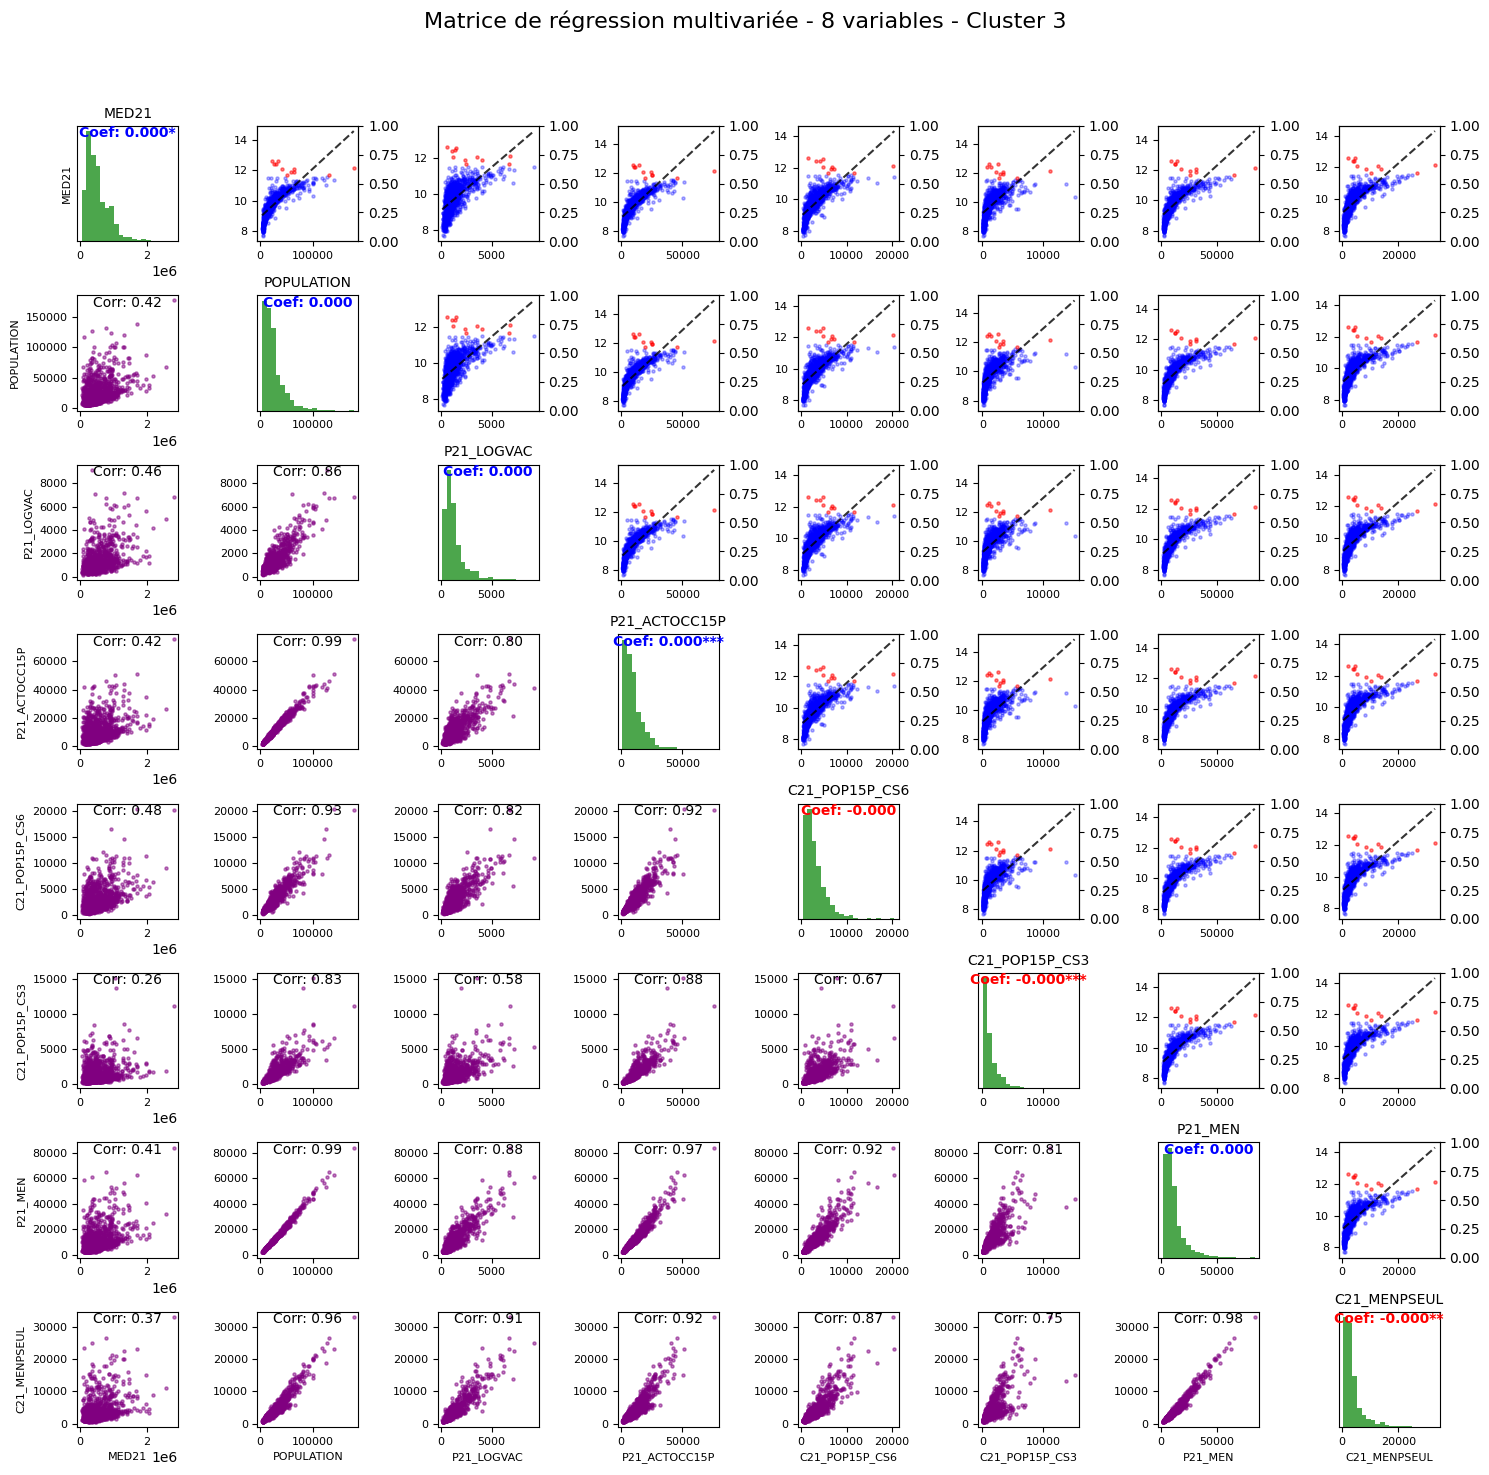

<Figure size 1000x600 with 0 Axes>

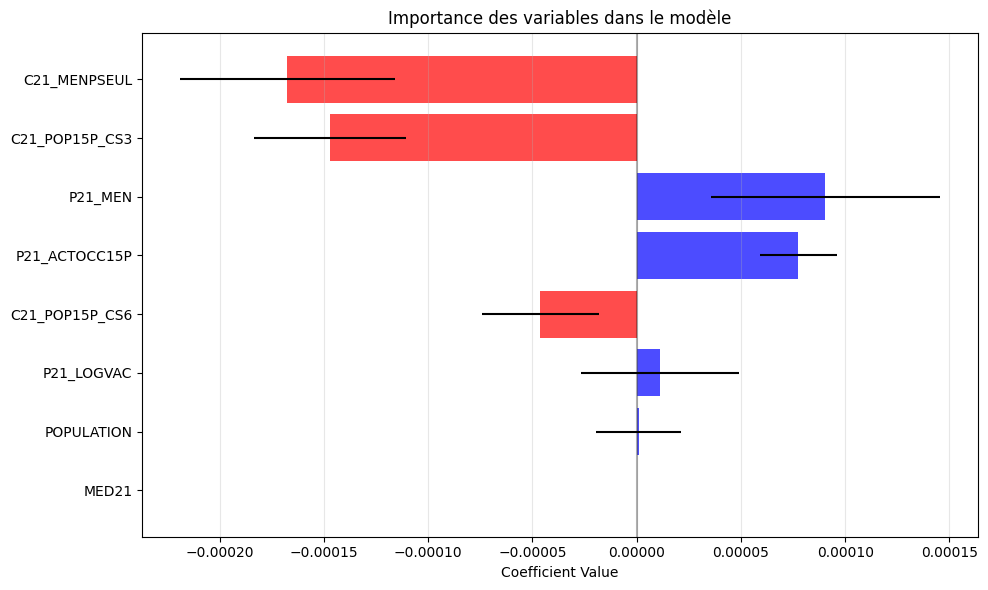

In [51]:
x_vars = [
    'MED21', 'POPULATION',
    'P21_LOGVAC',
    'P21_ACTOCC15P', 'C21_POP15P_CS6','C21_POP15P_CS3',
    'P21_MEN', 'C21_MENPSEUL']

model, data_used = regression_ols_cluster(
    epci_features_extended, mauvais_eleves_par_cluster, cluster_col='cluster',cluster_value=3, 
    y_col='pollution_flux_rouges', 
    x_cols=x_vars,
    log_y=True) 
